In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import cloudpickle
import xgboost
from sklearn.metrics import classification_report
from comparers import ModelComparer
from sklearn.model_selection import StratifiedKFold, train_test_split
from helper_models import LogProbabilityMixin
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
import matplotlib.pyplot as plt

XGBoost prints many warnings, that are safe to ignore:

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
try:
    with open('shap-values.pickle', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        comparer = ModelComparer(clf_a, clf_b, explanations.feature_names)
    is_pred_diff = comparer.predict_bin_diff(explanations.data)
    mclass_diff = comparer.predict_mclass_diff(explanations.data)
    print('Loaded state')
except FileNotFoundError:
    pass

Loaded state


# Setup Task

In [2]:
df = pd.read_csv('day.csv', parse_dates=['dteday'])
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


For this research, I simplify the regression problem to a binary classification problem: To predict, whether the bike share count is above a certain threshold.

In [3]:
is_over_threshold = df['cnt'] > 4500

In order to make use of the unique properties of this dataset and investigate the suitability for analysing data drift, I split it in two parts: classifier A is trained on data of year 2011 and classifier B on data of year 2012. This dataset is well known for its characteristic that bike sharing became more popular over time.

In [5]:
is_part1 = df['dteday'] < datetime(2012, 1, 1)

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

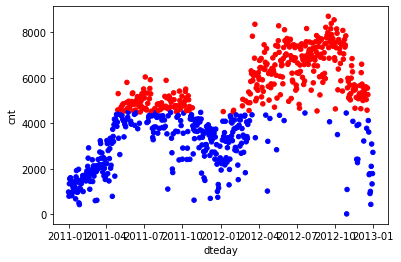

In [4]:
color = np.repeat('b', df.shape[0])
color[is_over_threshold] = 'r'
color
df.plot(x='dteday', y='cnt', kind='scatter', color=color)

I chose the threshold manually to yield similarly unbalanced training datasets.

In [6]:
np.sum(is_over_threshold[is_part1])

102

In [7]:
np.sum(~is_over_threshold[is_part1])

263

In [8]:
np.sum(is_over_threshold[~is_part1])

270

In [9]:
np.sum(~is_over_threshold[~is_part1])

96

I also remove the features yr and dteday from the dataset, because it doesn't contain usable information for the tasks.

In [10]:
feature_names = ['season', 'mnth', 'holiday', 'weekday', 'workingday',
                 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = df.loc[:, feature_names]
y = is_over_threshold.astype(int)

In [11]:
X_train1 = X[is_part1]
y_train1 = y[is_part1]
X_train2 = X[~is_part1]
y_train2 = y[~is_part1]

In [4]:
class XGBClassifierWithLogProbaPredict(xgboost.XGBClassifier, LogProbabilityMixin):
    pass

In [14]:
def make_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    skf = StratifiedKFold(n_splits=10)
    best_score = 0
    for train_index, test_index in skf.split(X_train, y_train):
        clf = XGBClassifierWithLogProbaPredict(n_jobs=4, use_label_encoder=False, eval_metric='logloss')
        clf.fit(X.iloc[train_index], y.iloc[train_index])
        score = clf.score(X.iloc[test_index], y.iloc[test_index])
        if score > best_score:
            best_clf, best_score = clf, score
        print(score)
    print(classification_report(y_test, best_clf.predict(X_test)))
    return best_clf

In [19]:
%%time
clf_a = make_classifier(X_train1, y_train1)

1.0
1.0
0.9310344827586207
0.8275862068965517
0.8620689655172413
0.6896551724137931
0.7586206896551724
0.6206896551724138
0.7931034482758621
0.6896551724137931
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        53
           1       0.91      1.00      0.95        20

    accuracy                           0.97        73
   macro avg       0.95      0.98      0.97        73
weighted avg       0.98      0.97      0.97        73

CPU times: user 2.77 s, sys: 441 ms, total: 3.21 s
Wall time: 13.2 s


In [20]:
%%time
clf_b = make_classifier(X_train2, y_train2)

0.9666666666666667
1.0
0.7931034482758621
0.8620689655172413
0.896551724137931
0.9655172413793104
0.9655172413793104
0.9655172413793104
0.9310344827586207
0.896551724137931
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.98      1.00      0.99        55

    accuracy                           0.99        74
   macro avg       0.99      0.97      0.98        74
weighted avg       0.99      0.99      0.99        74

CPU times: user 2.11 s, sys: 330 ms, total: 2.44 s
Wall time: 3.46 s


In [21]:
print(classification_report(y_train2, clf_a.predict(X_train2)))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57        96
           1       1.00      0.46      0.63       270

    accuracy                           0.60       366
   macro avg       0.70      0.73      0.60       366
weighted avg       0.84      0.60      0.61       366



In [22]:
import pickle

In [9]:
with open('classifiers.pickle', 'wb') as f:
    cloudpickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

In [25]:
comparer = ModelComparer(clf_a, clf_b, X.columns)

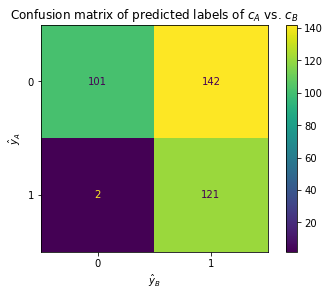

In [26]:
comparer.plot_confusion_matrix(X_train2)

In [27]:
is_pred_diff = comparer.predict_bin_diff(X_train2)
mclass_diff = comparer.predict_mclass_diff(X_train2)

In [28]:
import shap
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances

In [29]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X_train2, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])

Exact explainer: 367it [04:31,  1.33it/s]                         
Exact explainer: 367it [03:09,  1.83it/s]                         
Exact explainer: 367it [08:05,  1.35s/it]                         

CPU times: user 50min 11s, sys: 1min 45s, total: 51min 56s
Wall time: 15min 45s


In [32]:
with open('shap-values.pickle', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite), f, pickle.HIGHEST_PROTOCOL)

# Global Explanations

## Traditional Approach

### Feature importance

- temp has the highest importance for both classifiers
- holiday has 0 importance for both classifiers
- mnth, hum, atemp, weekday, workingday have bigger importance for A than for B
- season, weathersit have higher importance for B than for A

Based on this, I formulate the following theories:
- Both classifiers are influenced by time of the year: A more by month, B more by season
- Both classifiers are influenced by weather conditions: A more by temperature and humidity, B more by weathersituation
- holiday is not used to make decisions, because workingday is already sufficient and is better suited
- B depends less on weekday and workingday, possibly indicating a shift of habits

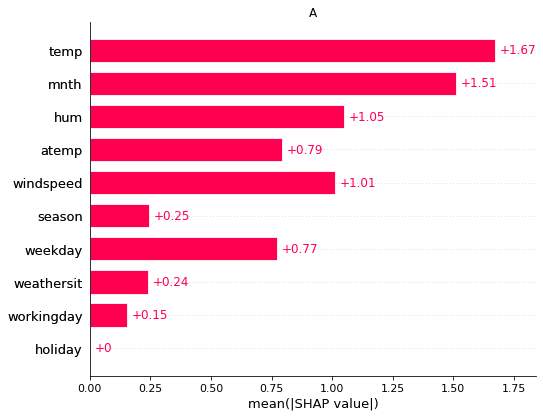

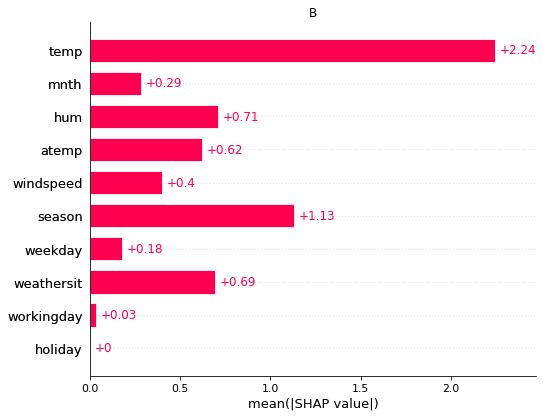

In [75]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds[:, :, 1])
plot_feature_importance_bar(explanations.indiv.log_odds.A[:, :, 1], title='A', feature_order=feature_order)
plot_feature_importance_bar(explanations.indiv.log_odds.B[:, :, 1], title='B', feature_order=feature_order)

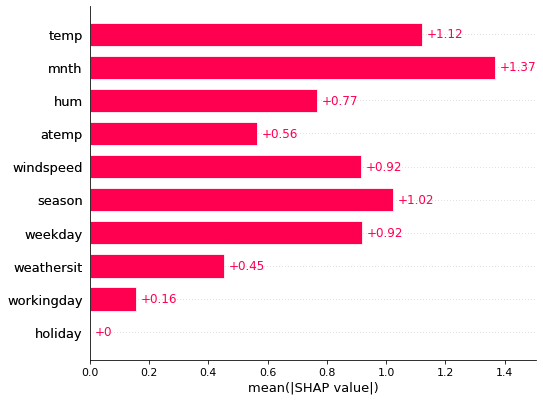

In [76]:
plot_feature_importance_bar(explanations.indiv_diff.log_odds[:, :, 1][:, feature_order])

Since holiday has no importance to both classifiers, I do not analyze it more closely.

In [91]:
feature_order = feature_order[:9]

The most important feature temp is different in its distribution for low values: for A, low values indicate a clear reduction of log odds (approx. -2), while it is not so clear for B. Here, SHAP values are spread from -4 to +1.

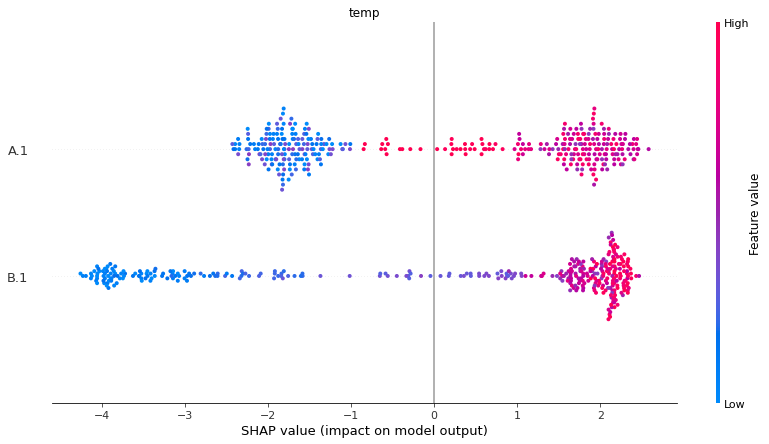

In [77]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[0]], 1])

Month clearly has positive influence for A for mid to high feature values, and even bigger negative influence for low feature values. The distribution is different for B: there are two groups of instances with low feature values, one where there is a slight positive and one with a sligh negative influence. Mid to high feature values seem to have nearly no influence at all.

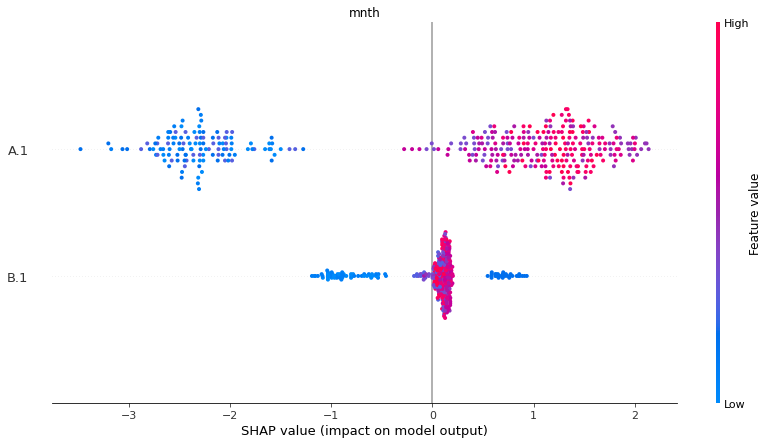

In [78]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[1]], 1])

For humidity, high values indicate varying degrees of negative influence. Low feature values have higher impact on A than on B.

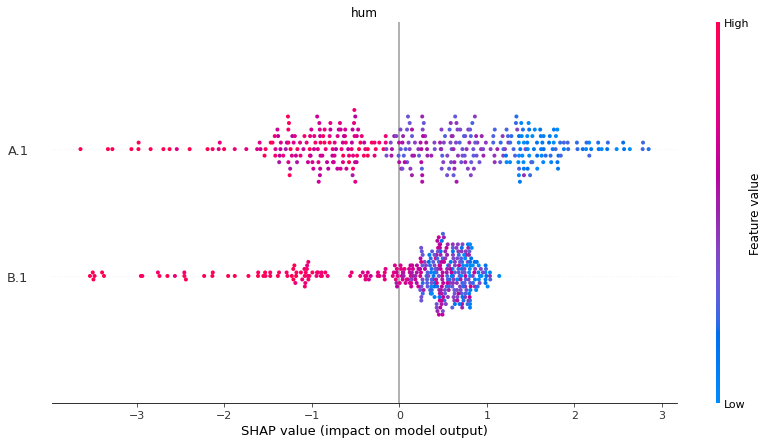

In [79]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[2]], 1])

High feature values of atemp influence the models differently: For A, the it has quite diverse effects ranging from -3 to +2, whereas for B, it just indicates a small positive influence. I expect interactions to be present with temp and hum because of their close relation.

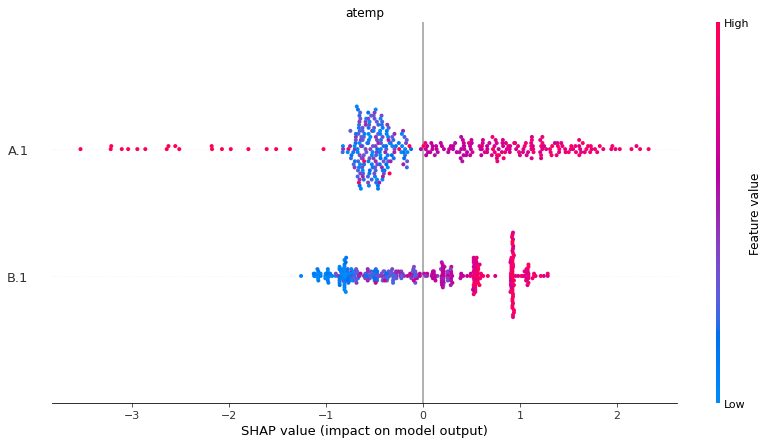

In [80]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[3]], 1])

Windspeed has higher and more extreme influence on model A than B.

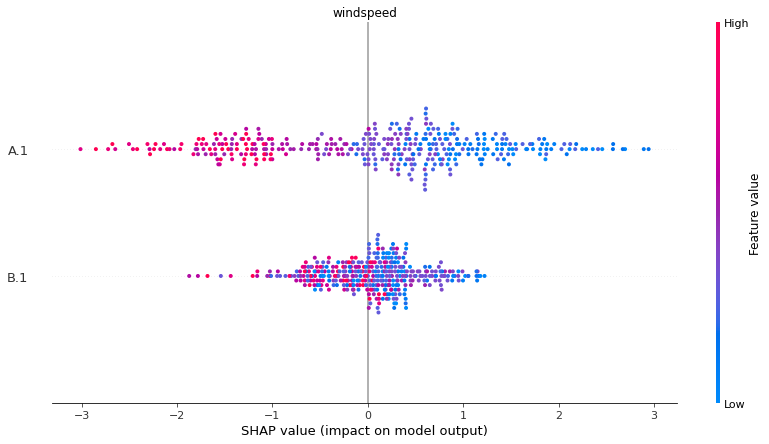

In [81]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[4]], 1])

Low values of season (winter) has much bigger negative influence on model B than on A. This shifts the SHAP values for other seasons to the right.

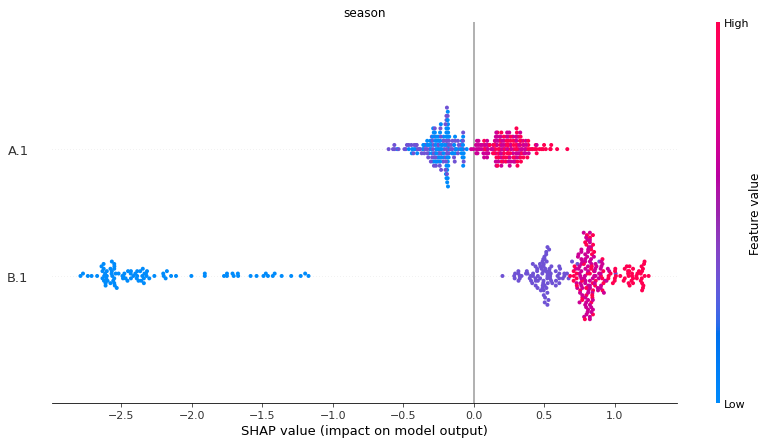

In [82]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[5]], 1])

Even though the influences on model B are small, they are the opposite of those on model A. The choice of the encoding of the weekdays is unfortunate in this case, because it starts with Sunday being 0, splitting the weekend. Nevertheless, there is a trend from negative to positive influence from Sunday till Saturday.

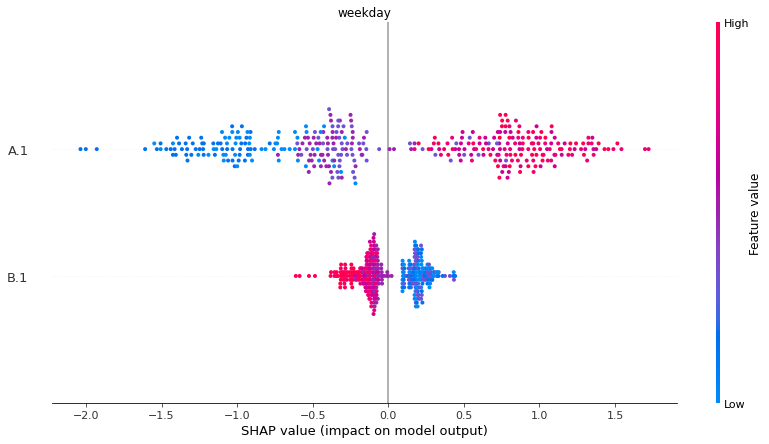

In [83]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[6]], 1])

For B, high values of weathersit (snow and rain) have bigger negative influence and low values (clear to mist) have bigger positive influence than for A.

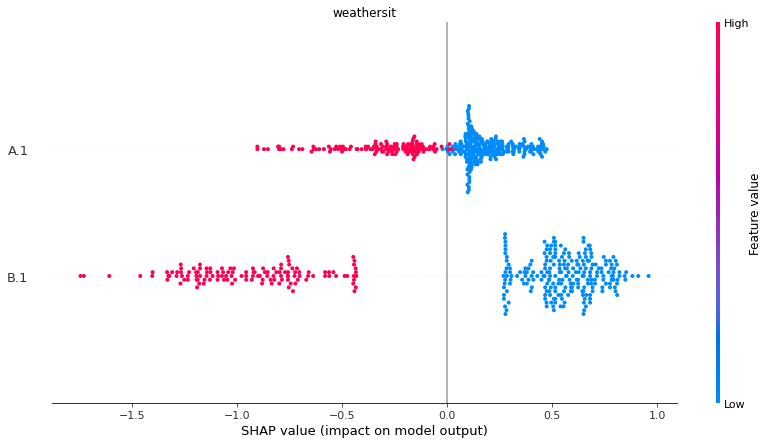

In [84]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[7]], 1])

Workingday is considered more important by A, which also shows a clearer separation of low and high values, low values (weekend or holiday) having positive influence on the outcome. For B, the effect may depend on other features as well.

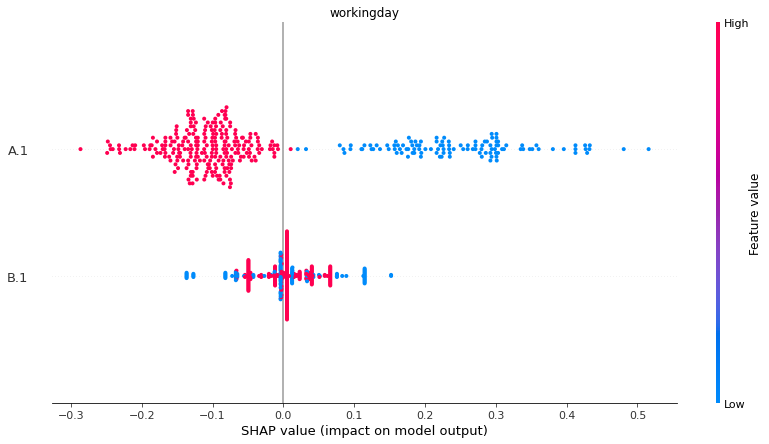

In [85]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, [feature_order[8]], 1])

### Feature Effects

Comparing the effects of temp, we can see that they are more negative below 0.5 for B, and that the shift is gradual. Below 0.2, there are no instances classified differently. On the upper end, it has a slight negative influence on A whereas on B a positive influence. In A we see, that instances classified differently have generally lower SHAP values for the same feature values than instances classified equally. This means, that there are interaction effects present.

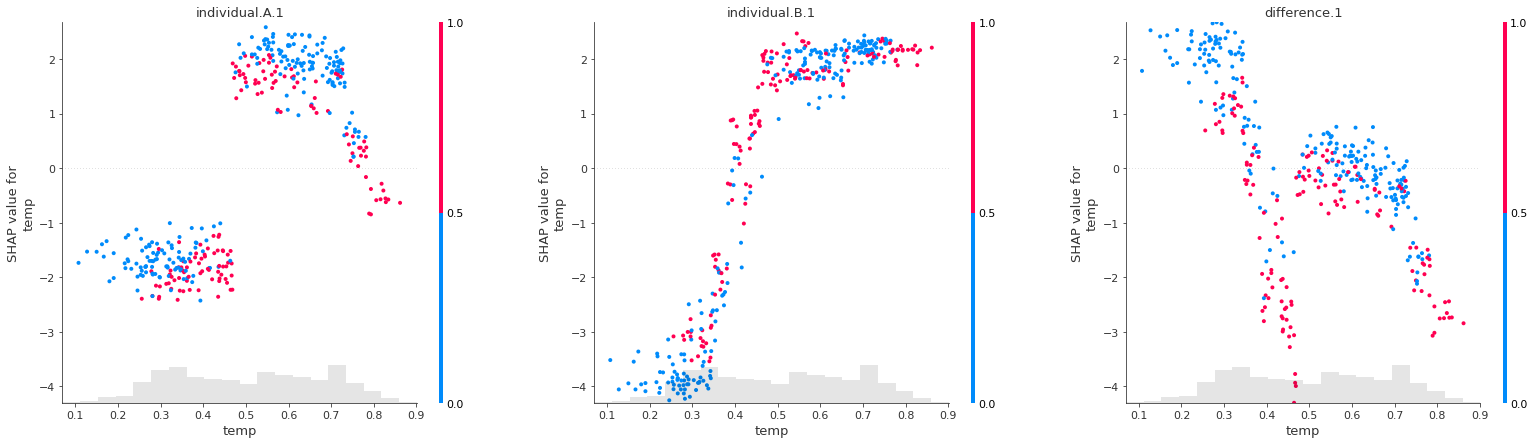

In [96]:
feature = feature_order[0]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

As I noted in the feature importance section, individiual months have higher influence on model A than B. Especially for months 3 and 4 there is a negative influence on A but positive or close to no influence on B. Similarly to the effects plots of temp, we see a vertical separation of instances classified differently and equally, which means, interaction effects are present.

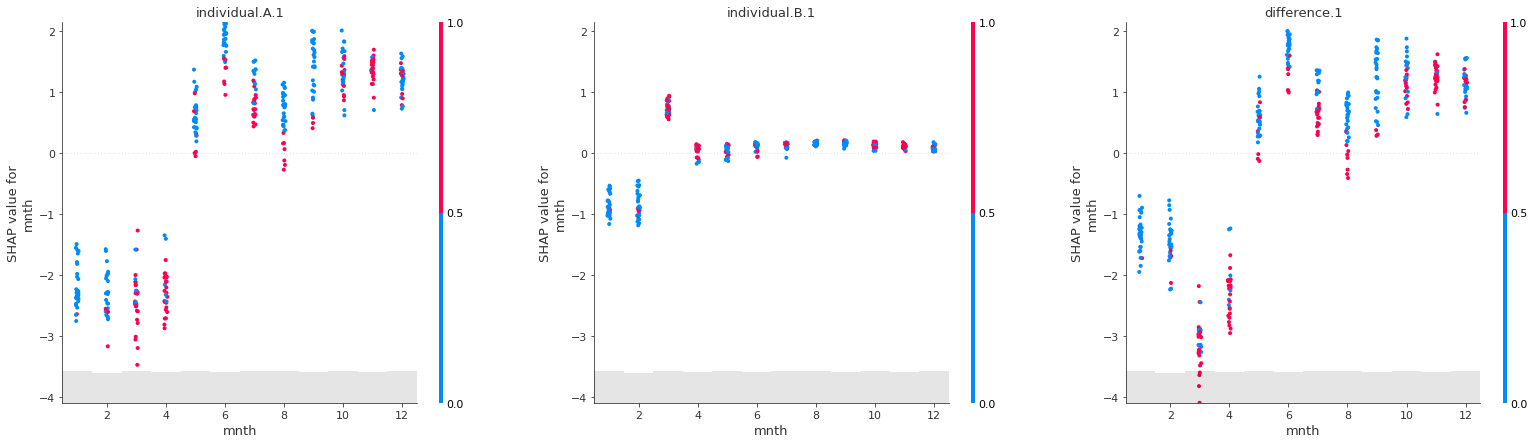

In [97]:
feature = feature_order[1]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

hum differs mainly for feature values below 0.5, were there is increasing positive influence on A but nearly constant influence near 1 on B.

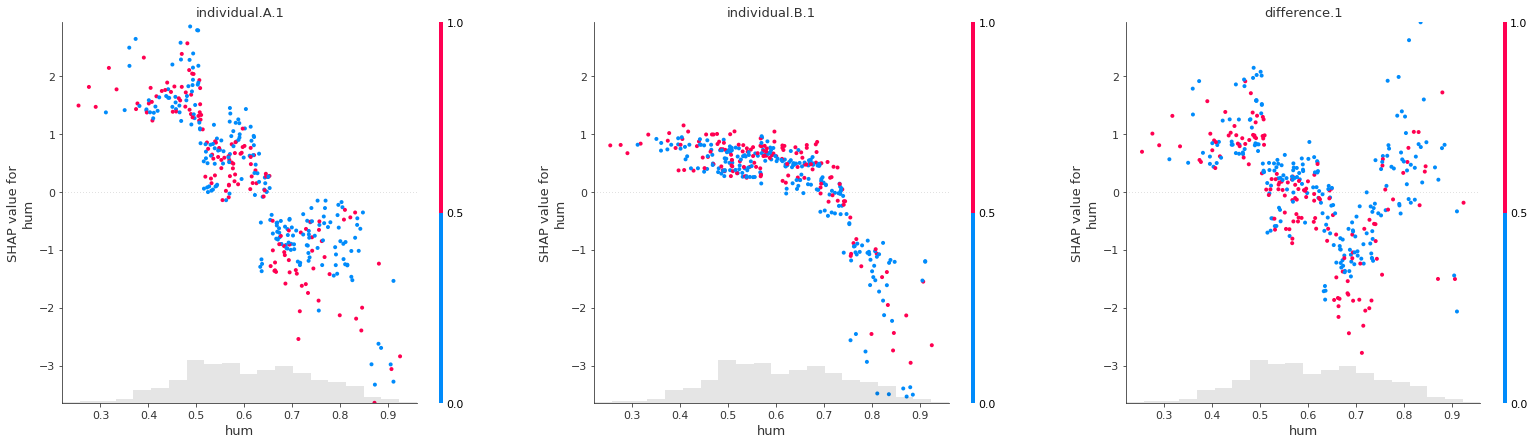

In [98]:
feature = feature_order[2]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

The effects of atemp look similar, except for values above 0.7, where all instances are classified differently. Here we observe a negative influence on A but positive influence on B.

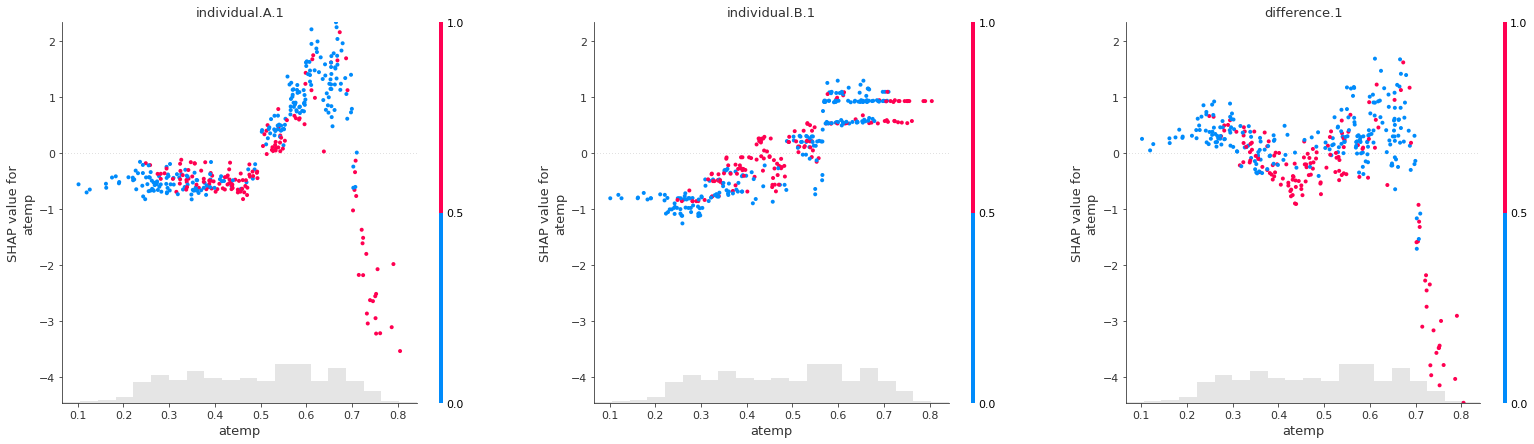

In [99]:
feature = feature_order[3]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

windspeed has a more pronounced effect on A than on B, where it is nearly random noise.

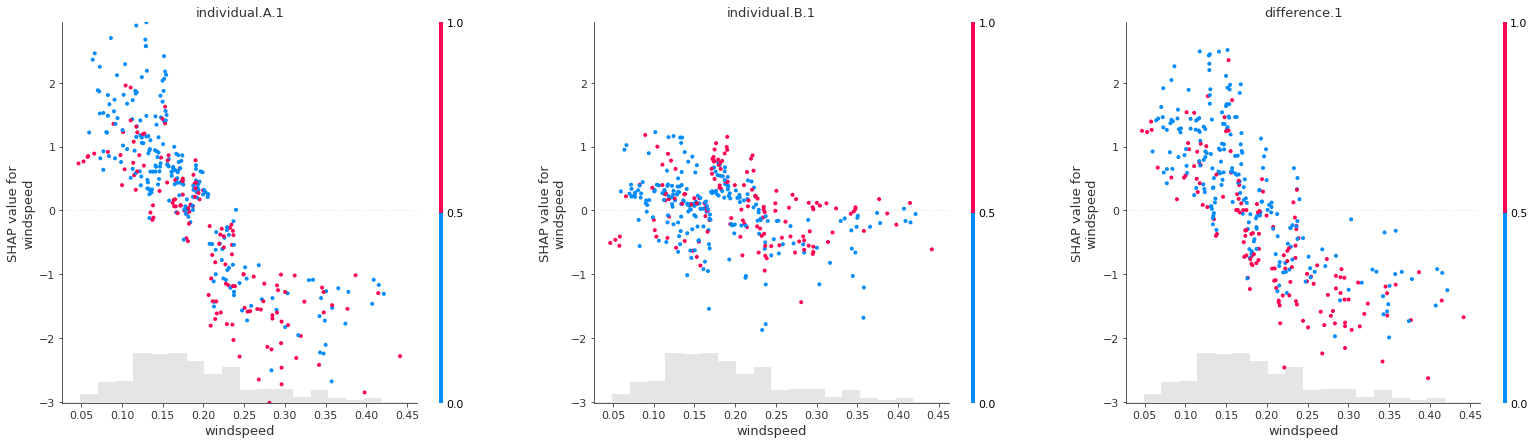

In [100]:
feature = feature_order[4]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

As noted earlier, season has higher influence on B than on A. Especially for season = 1 in B's effects, we see strong interaction effects because instances classified differently tend to have higher SHAP values.

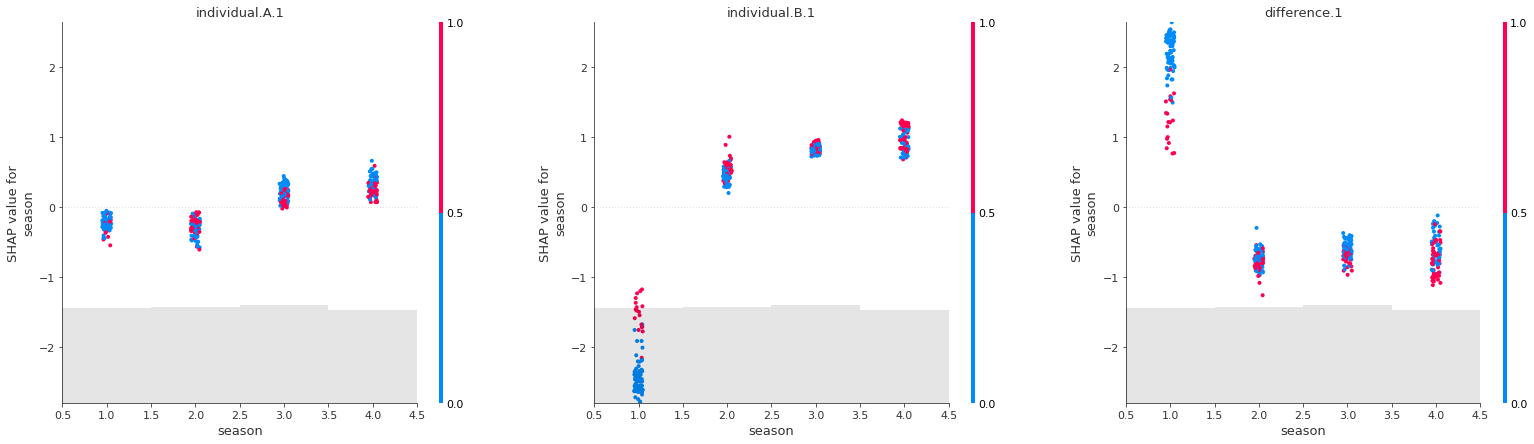

In [101]:
feature = feature_order[5]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

weekday has an increasing influence from low to high values on A, whereas on B there is only slight influence which is decreasing.

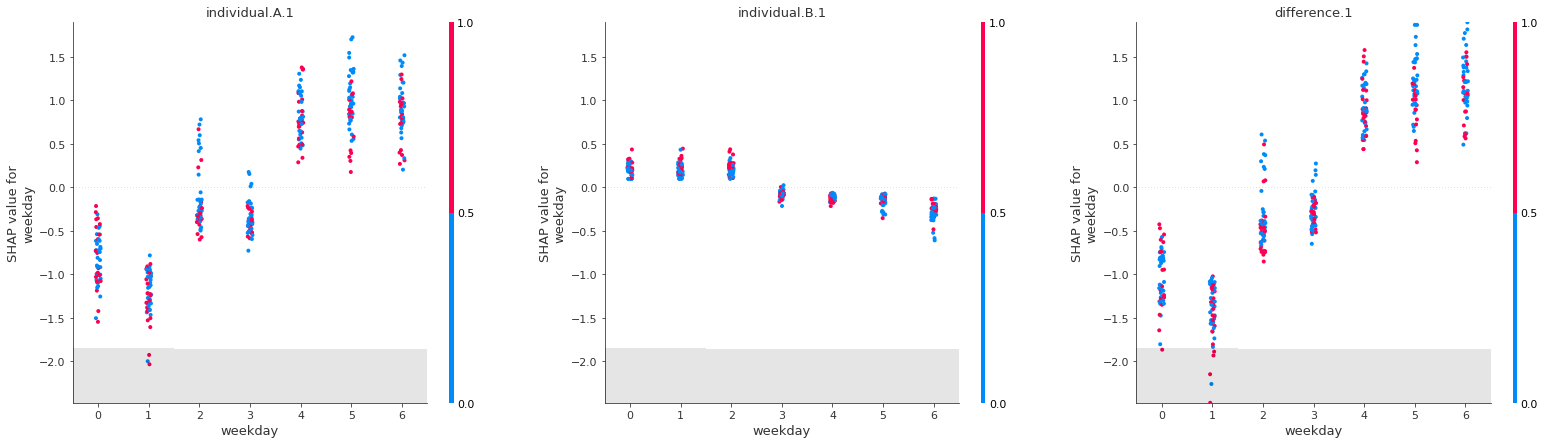

In [103]:
feature = feature_order[6]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

Weathersituation has more extreme influence on B than on A, possibly being a better indicator in the newer model than windspeed and hum combined.

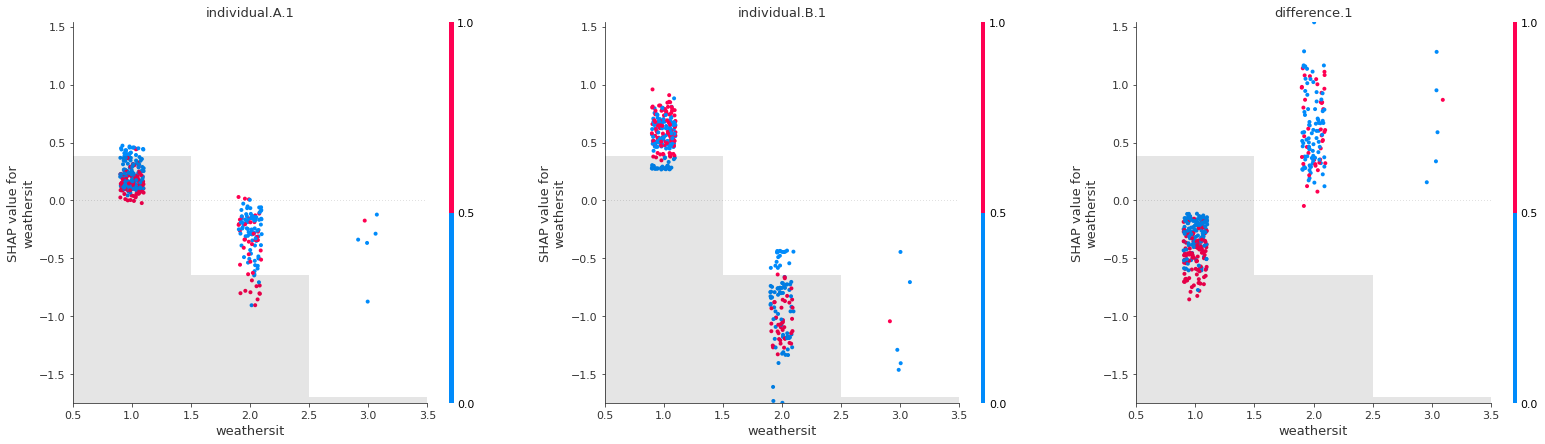

In [104]:
feature = feature_order[7]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

Workingday has a pronounced influence on A, but not on B. With weekday showing similar results, I assume that model A differentiates more between work and leisure time, with more people using bicycles in their leisure time and/or in the second half of the week.

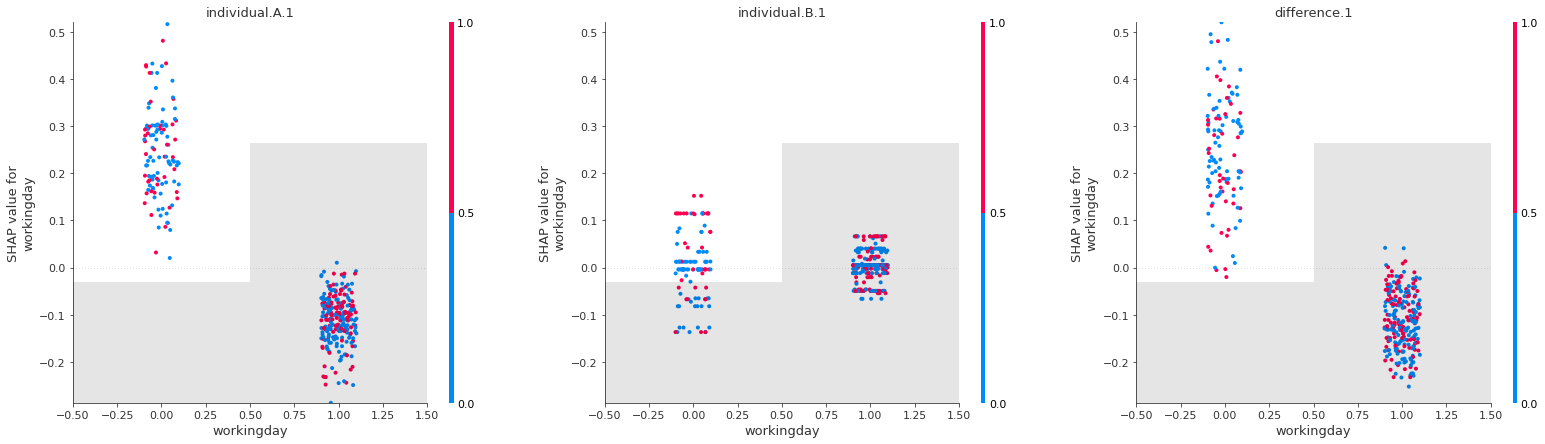

In [105]:
feature = feature_order[8]
plot_feature_effects(merge_explanations(individual=explanations.indiv.log_odds[:, [feature], 1],
                                        difference=explanations.indiv_diff.log_odds[:, [feature], 1]),
                     color=is_pred_diff)

## Difference classifier explanations

### Feature importance

In the feature importance plot for the difference classes we see that there is a significant drop in importance for workingday, considering this the knee or elbow point I will not investigate the last two features in the following analysis.

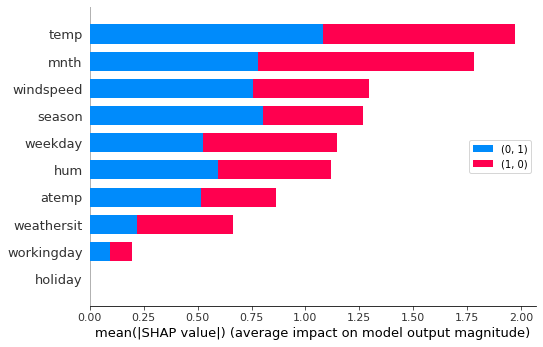

In [4]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.log_odds[:, :, comparer.difference_classes])
plot_feature_importance_bar(explanations.mclass_diff.log_odds[:, :, comparer.difference_classes])

In [5]:
feature_order = feature_order[:8]

Considering that there are only four classes and all have importance, I will stick to the original ordering.

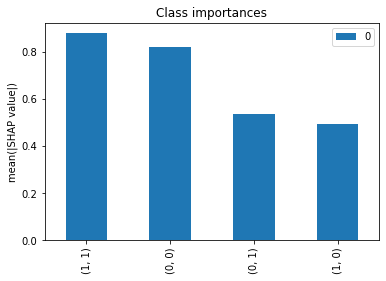

In [6]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [7]:
it = iter(feature_order)

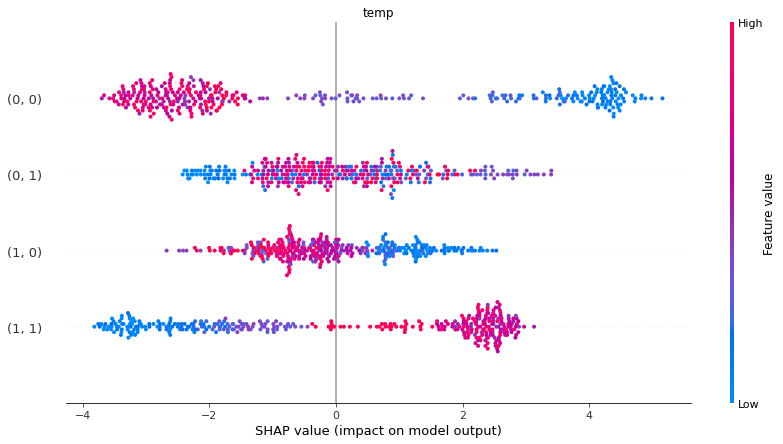

In [8]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [next(it)]])

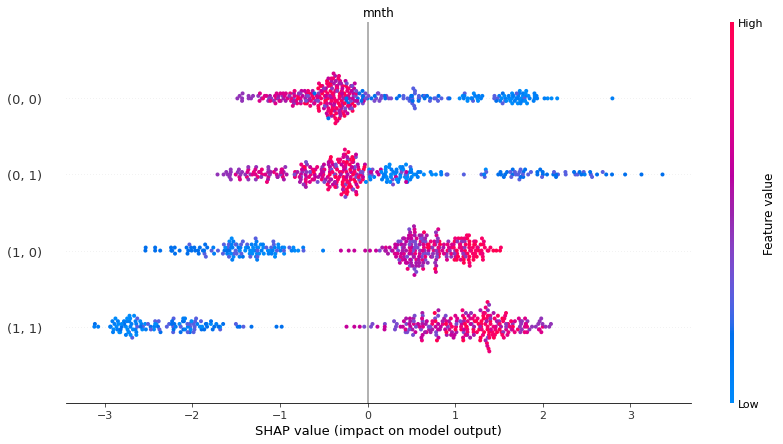

In [9]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [next(it)]])

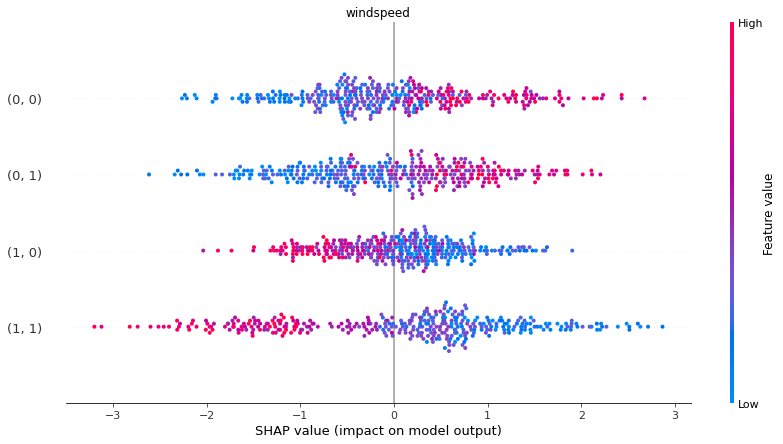

In [10]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [next(it)]])

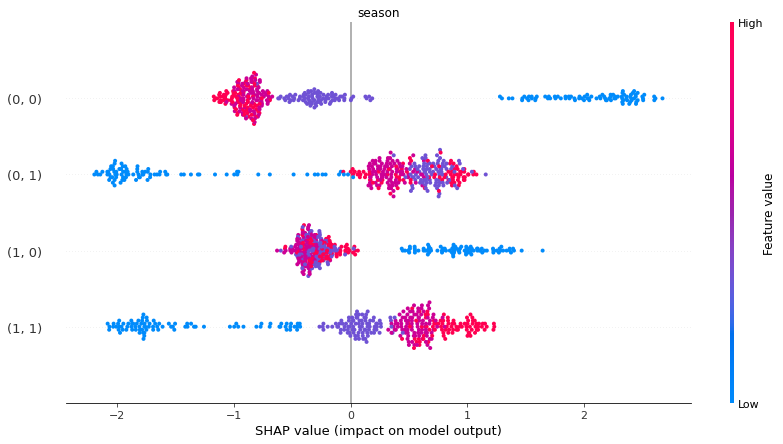

In [11]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [next(it)]])

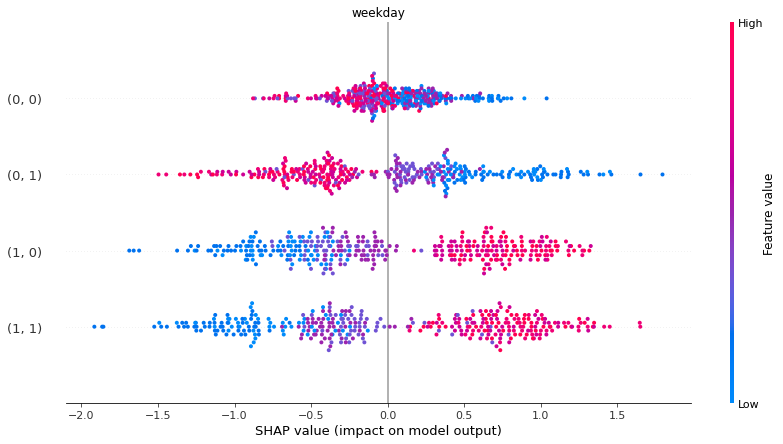

In [12]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [next(it)]])

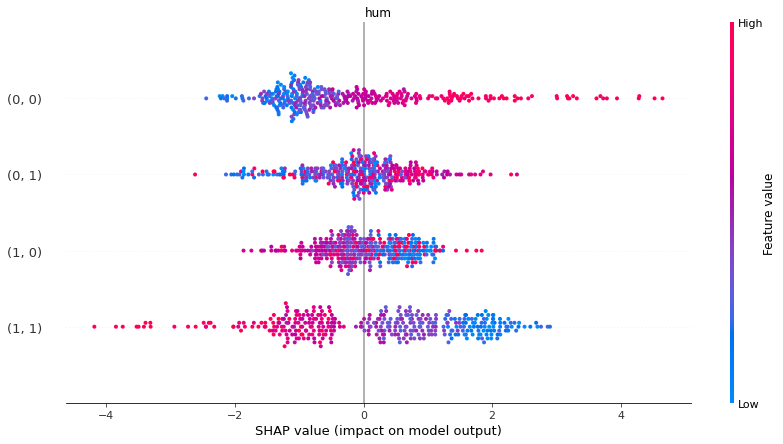

In [13]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [next(it)]])

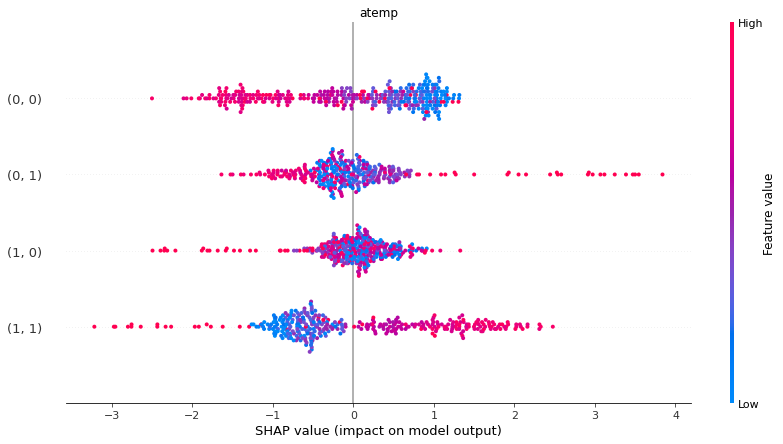

In [14]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [next(it)]])

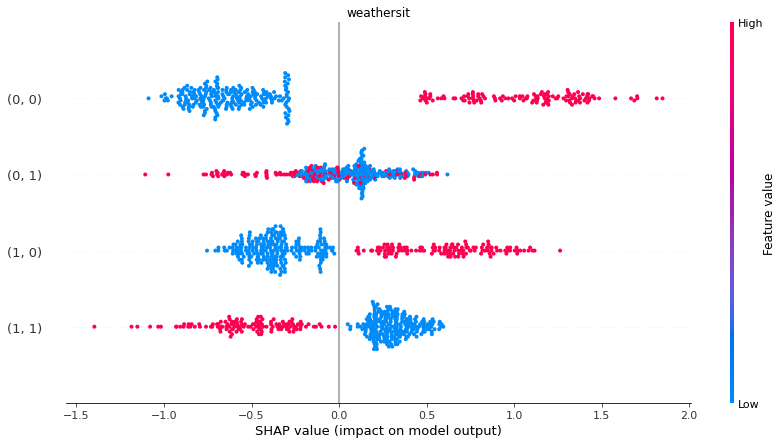

In [15]:
plot_feature_importance_scatter(explanations.mclass_diff.log_odds[:, [next(it)]])

### Feature effects

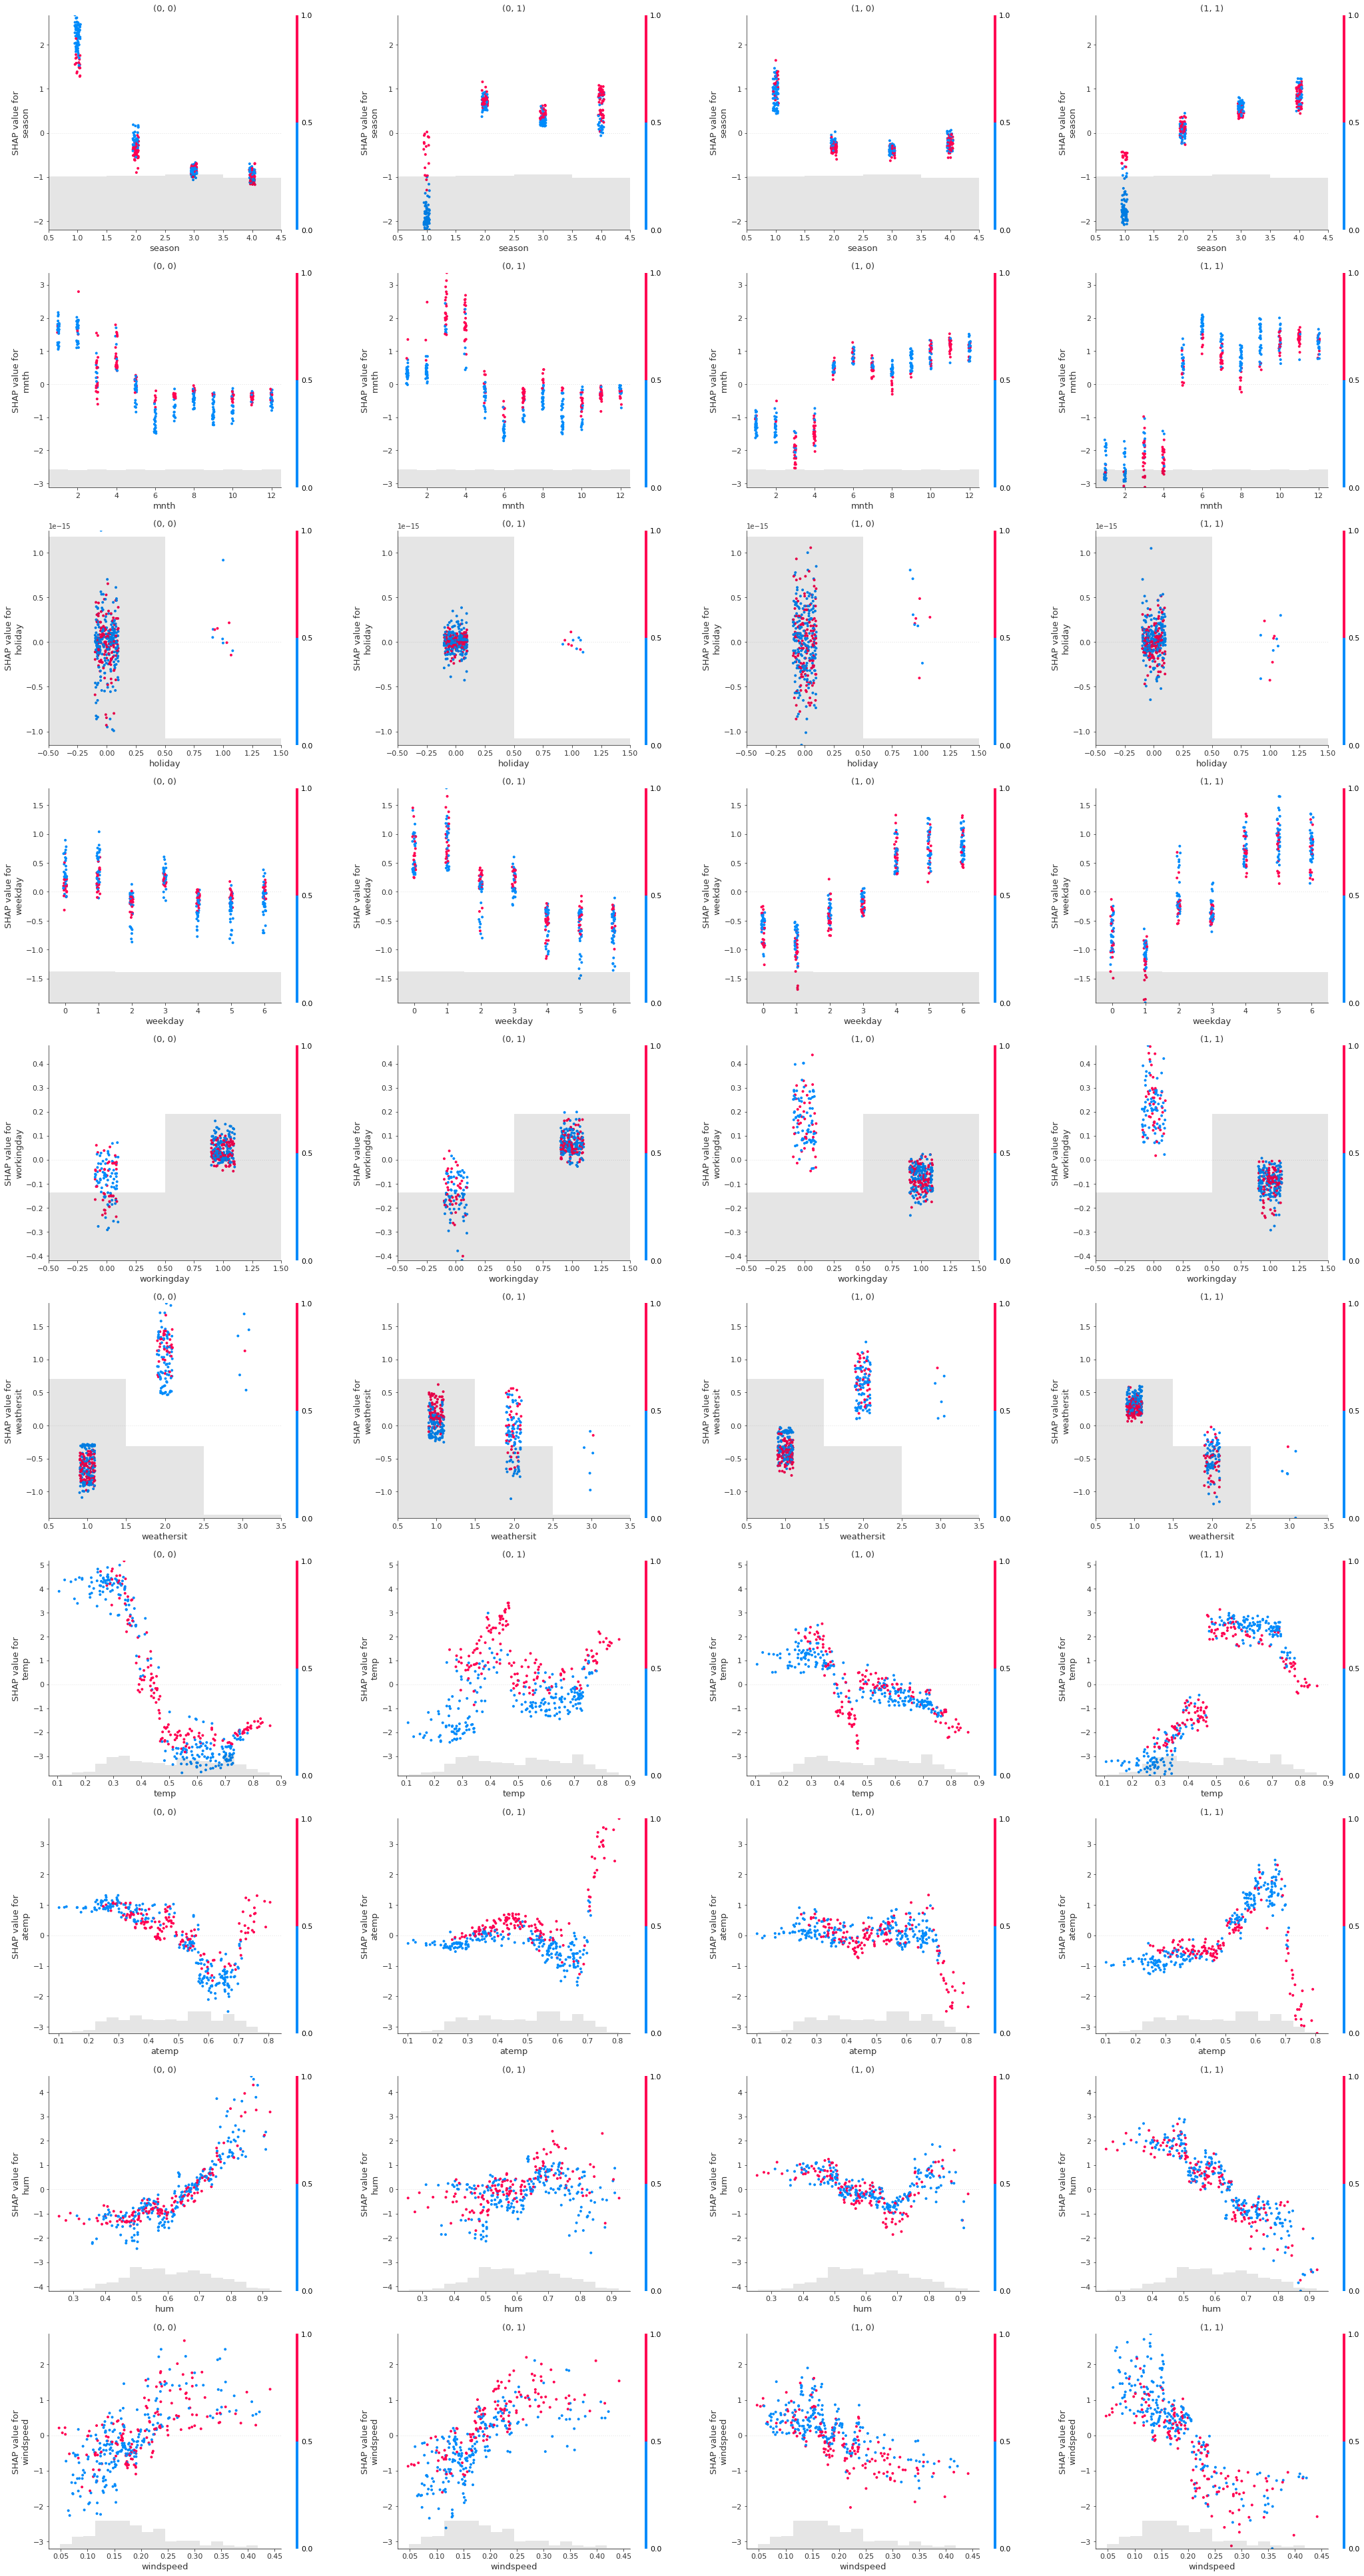

In [40]:
plot_feature_effects(explanations.mclass_diff.log_odds, color=is_pred_diff)

# Local Explanations

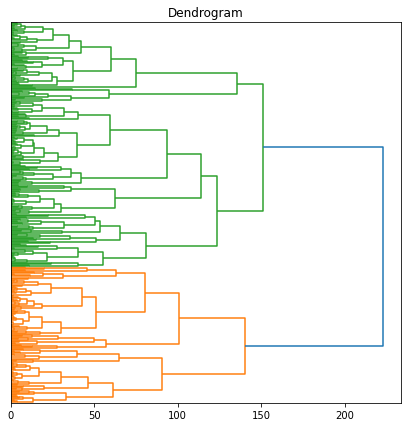

In [4]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.log_odds)
plot_dendrogram(linkage_matrix)

Guessing from the plot above, a reasonable cluster number could be 5. It yields a clustering, where every cluster contains instances classified differntly by the two classifiers. Cluster one is more diverse, having instances of all four classes. The other clusters are more homogenous, each containing instances of one difference class and one equality class.

In [5]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=5)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,18,31,2,1
c2,75,4,0,0
c3,0,95,0,64
c4,8,5,0,0
c5,0,7,0,56


Generating fewer clusters merges the last two, leading to it having instances of three classes. This is not an option.

In [6]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=4)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,18,31,2,1
c2,75,4,0,0
c3,0,95,0,64
c4,8,12,0,56


Increasing the number of clusters splits cluster 3. This could be an option if I later find out that the cluster is very heterogenous.

In [7]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=6)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,18,31,2,1
c2,75,4,0,0
c3,0,48,0,3
c4,0,47,0,61
c5,8,5,0,0
c6,0,7,0,56


In [8]:
clustering_, cluster_names_ = extract_clustering(linkage_matrix, n_clusters=7)
explanations_clustered_ = explanations.cohorts(cluster_names_[clustering_])
occurences_, clusters_of_interest_ = get_class_occurences_in_clusters(explanations_clustered_, cluster_names_, comparer)
occurences_

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,18,31,2,1
c2,75,4,0,0
c3,0,48,0,3
c4,0,28,0,0
c5,0,19,0,61
c6,8,5,0,0
c7,0,7,0,56


## 1st Cluster

In [11]:
cluster = clusters_of_interest[0]
confusion_class = '(0, 1)'
shap_values = explanations_clustered.mclass_diff.log_odds.cohorts[cluster]
instances_confused = comparer.predict_mclass_diff(shap_values.data) == comparer.class_names.tolist().index(confusion_class)

### Decision plots

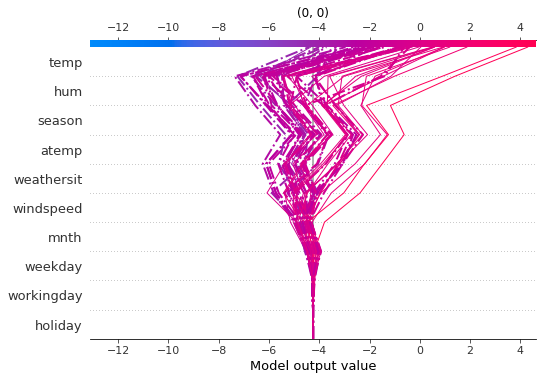

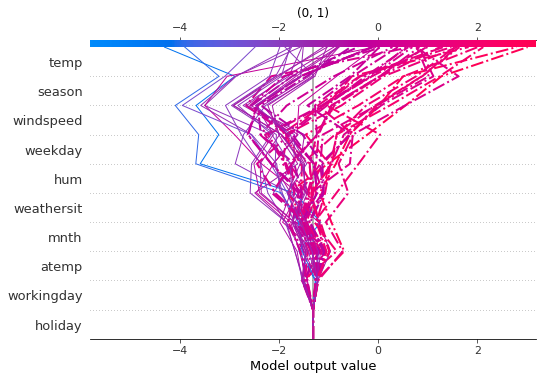

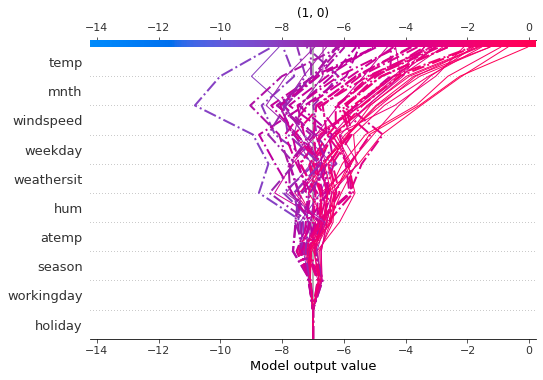

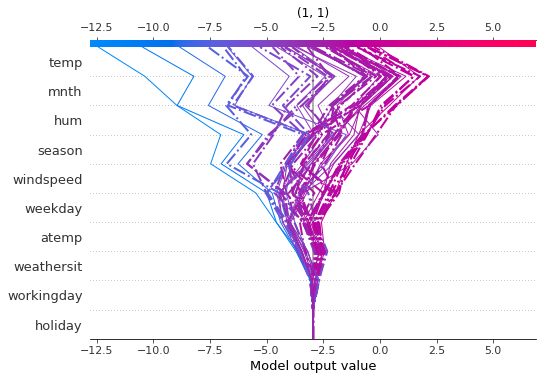

In [13]:
plot_decision(shap_values, highlight=instances_confused)

### Feature importances

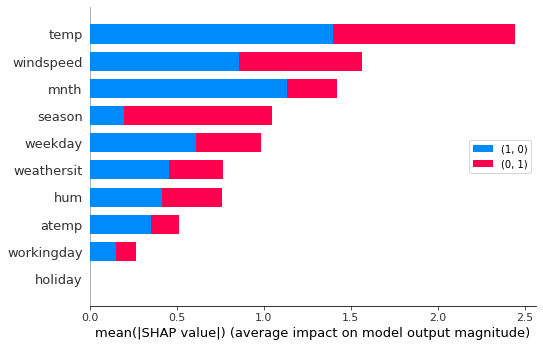

In [42]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, comparer.difference_classes])
plot_feature_importance_bar(shap_values[:, :, comparer.difference_classes])

The rule of thumb here is, that all features are included in subsequent analysis, that are above the knee point of the importance curve.

Here I include all but the last feature.

In [46]:
feature_order = feature_order[:-1]

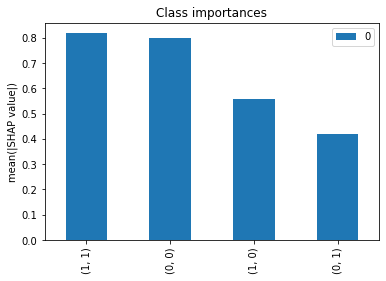

In [47]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

All classes are represented in the importances plot.

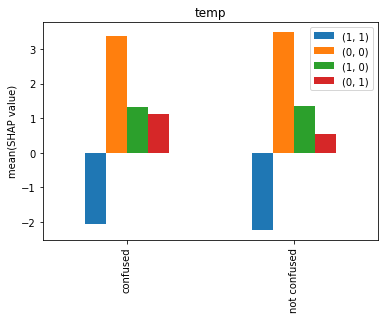

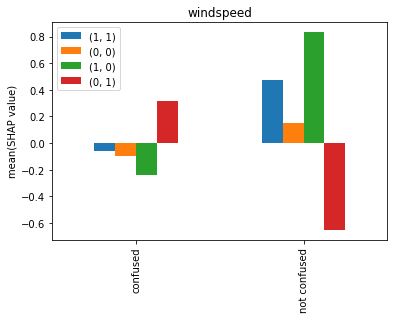

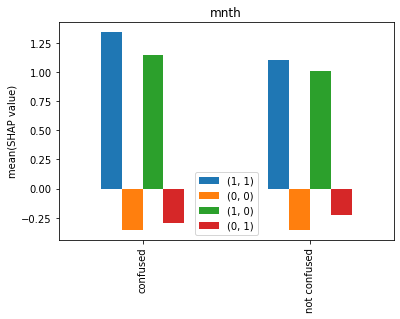

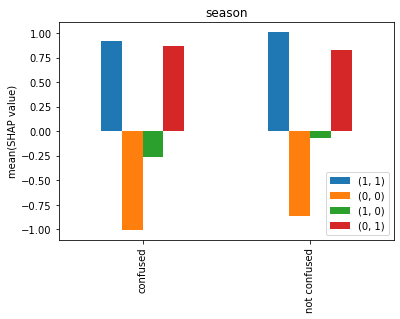

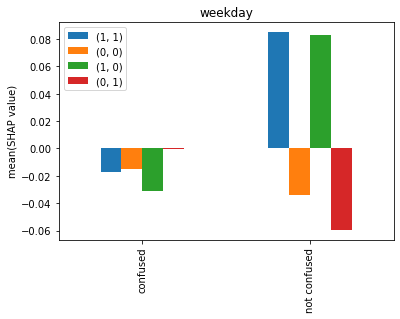

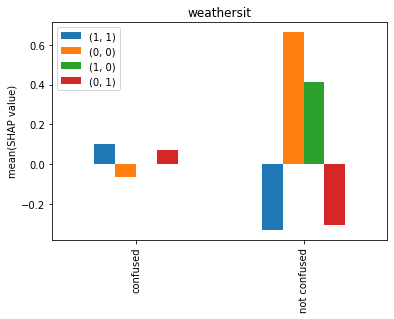

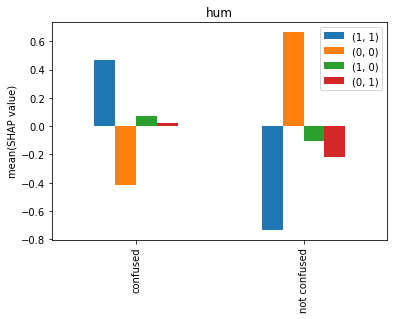

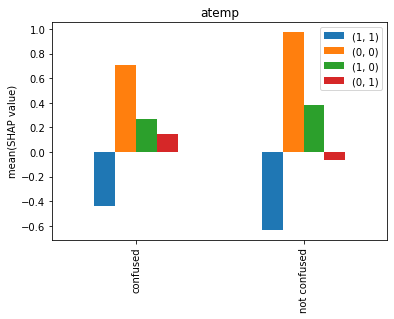

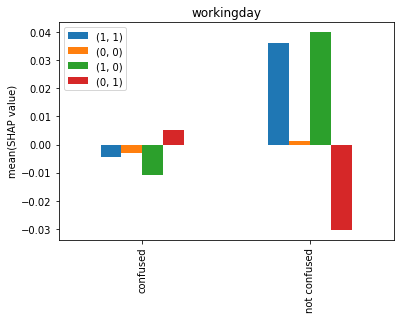

In [48]:
plot_feature_influence_comparison(shap_values, instances_confused, feature_order, class_order)

### Feature effects

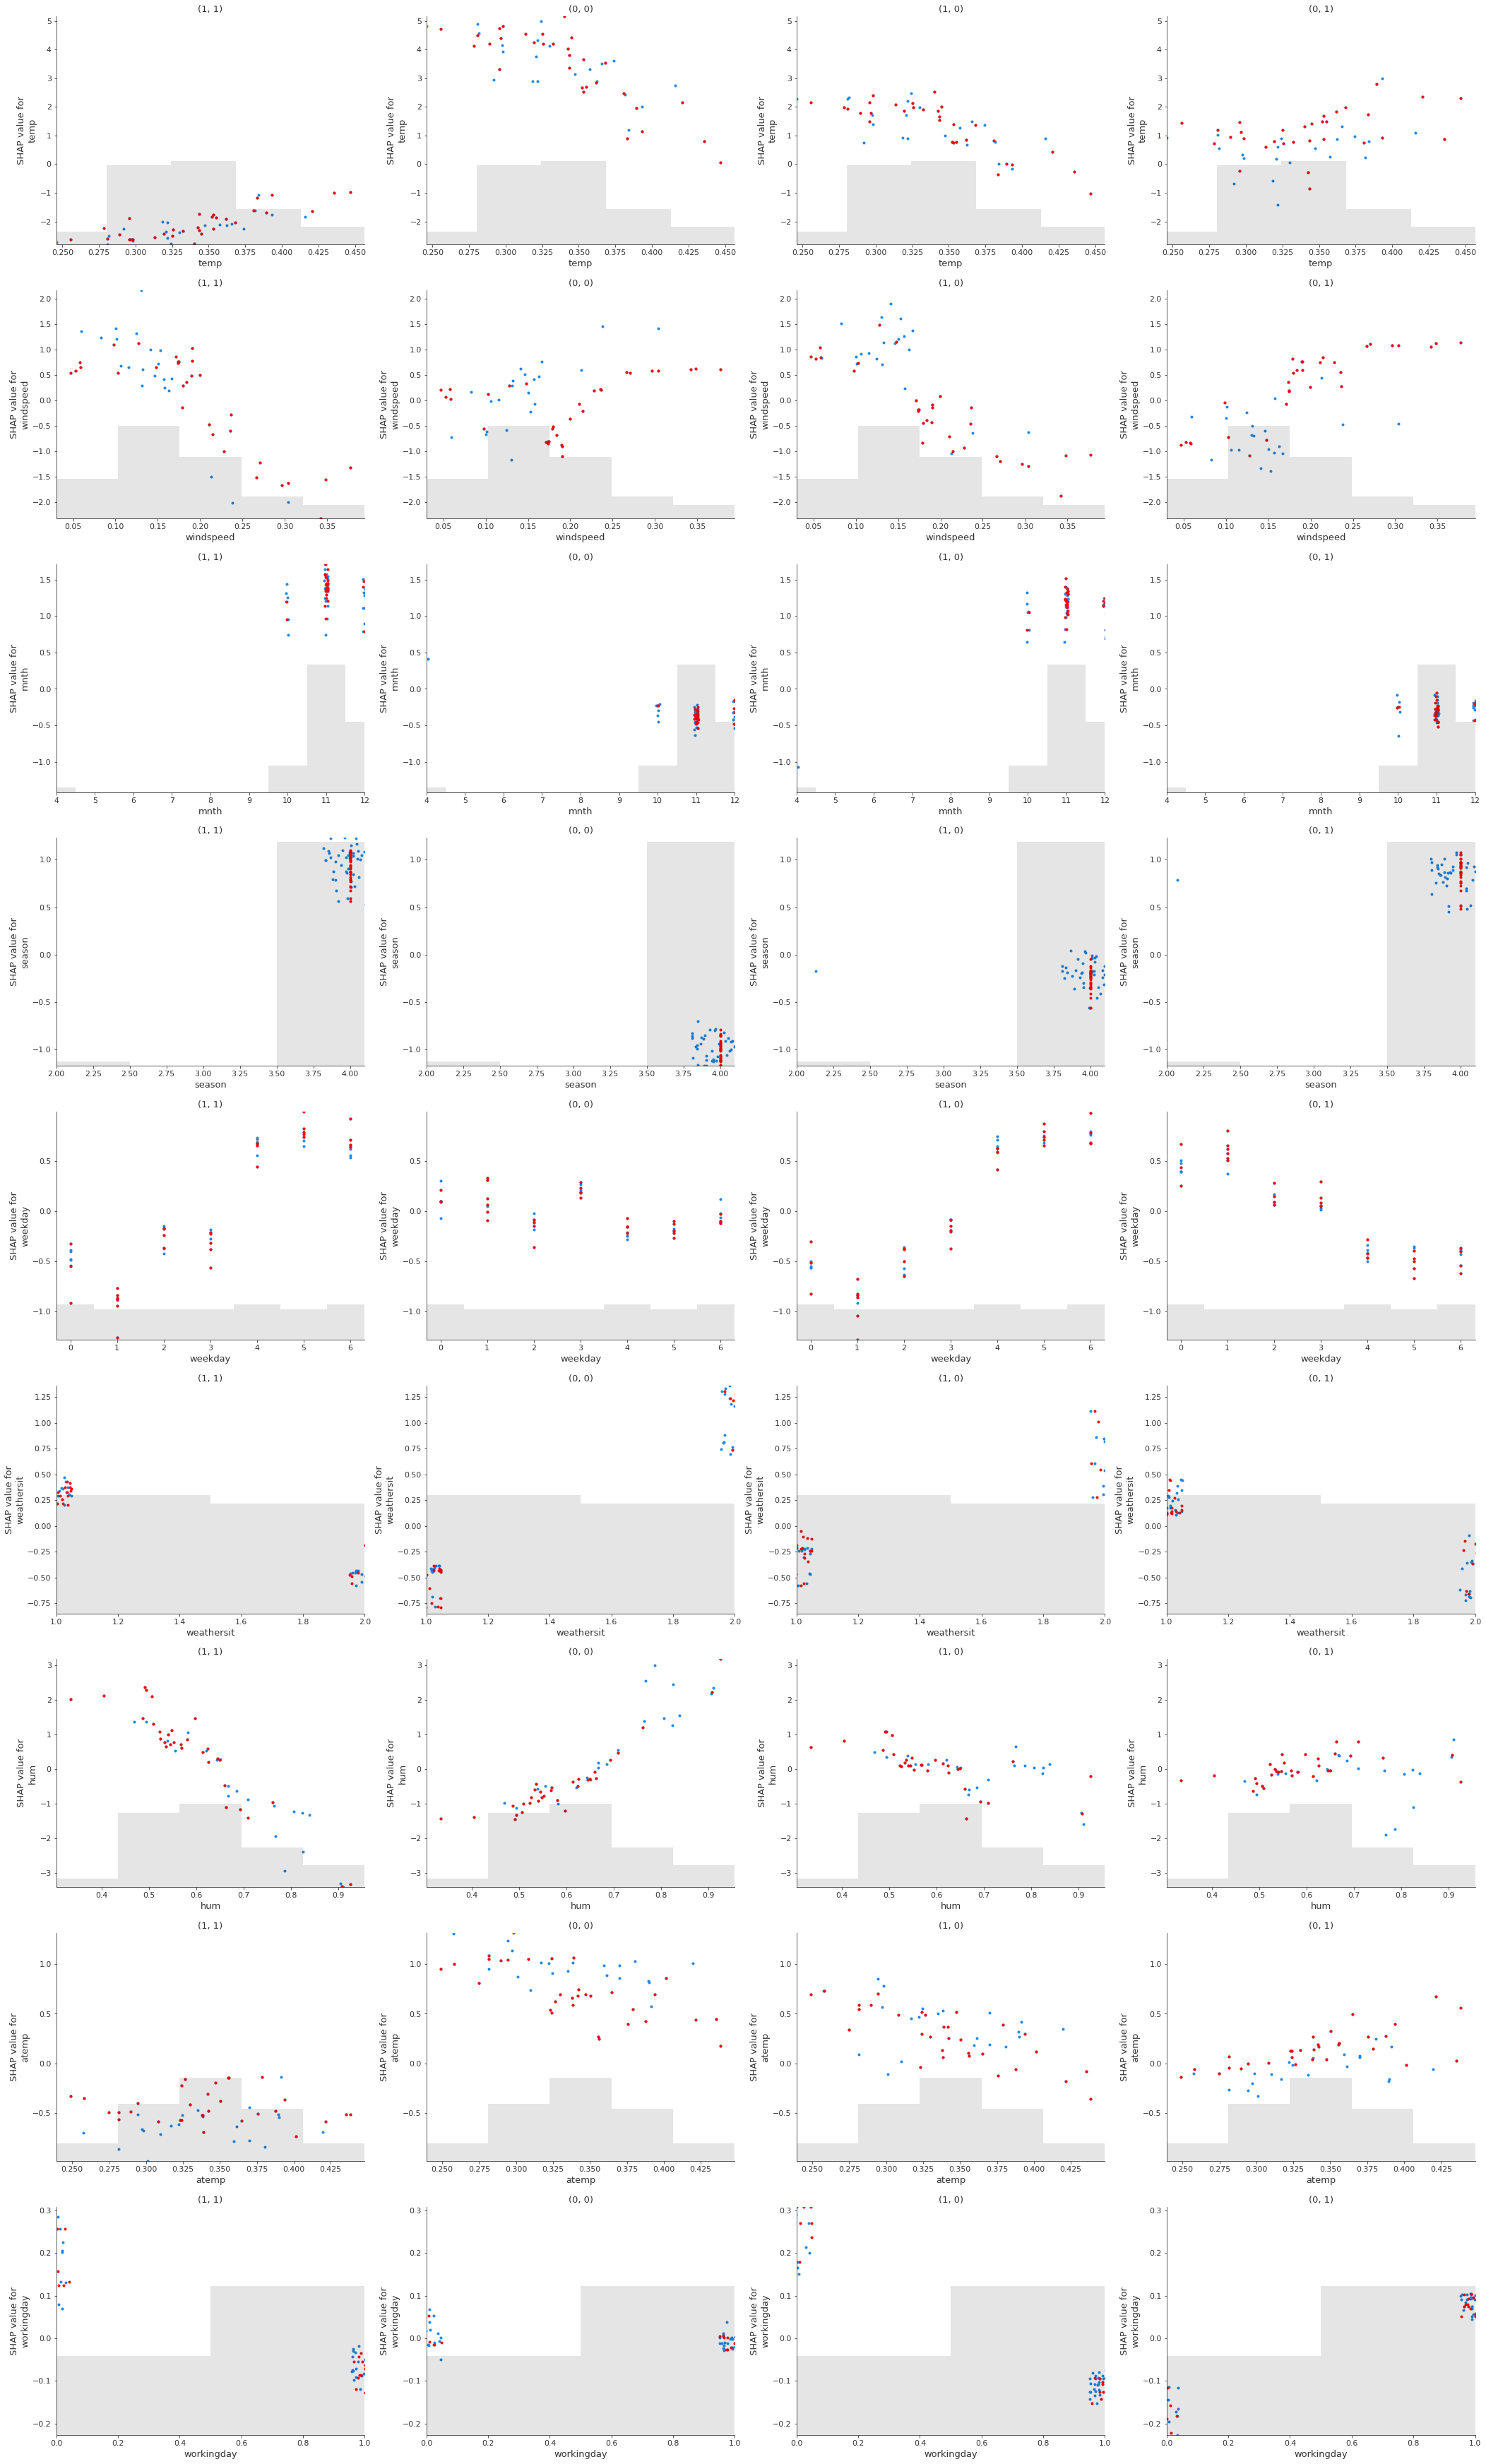

In [49]:
plot_feature_effects(shap_values[:, feature_order][:, :, class_order], highlight=instances_confused)

### diro2c

In [19]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, 0, comparer, confusion_class)

CPU times: user 10min 32s, sys: 39.2 s, total: 11min 11s
Wall time: 3min 11s


In [65]:
with open(f'diro2c.{cluster}.pickle', 'wb') as f:
    pickle.dump(explanation, f)

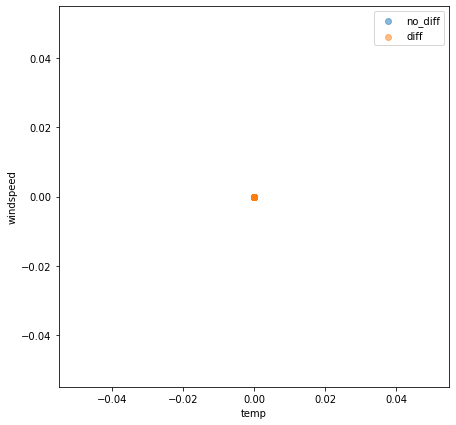

In [61]:
plot_diro2c_2d(explanation, feature_order[0], feature_order[1])

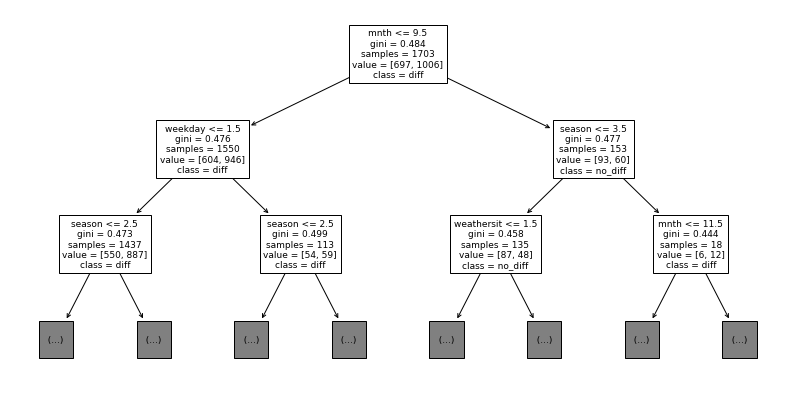

In [64]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=2, ax=ax)